In [199]:
find_median = function(values, dates, train_before=2020) {
    idx = year(dates) < train_before
    state_deaths = data.frame(weeks=MMWRweek(NCP_week$WeekDate)$MMWRweek, values=values, dates=dates)
    median = state_deaths[idx,] %>% group_by(weeks) %>% summarise(med = median(values, na.rm=TRUE))
    merged = merge(state_deaths, median, by="weeks")
    merged$med[order(merged$dates)]
}
find_quantile = function(values, dates, q = .95, train_before=2020) {
    idx = year(dates) < train_before
    state_deaths = data.frame(weeks=MMWRweek(NCP_week$WeekDate)$MMWRweek, values=values, dates=dates)
    median = state_deaths[idx,] %>% group_by(weeks) %>% summarise(est = quantile(values, probs=c(q), na.rm=TRUE))
    merged = merge(state_deaths, median, by="weeks")
    merged$est[order(merged$dates)]
}
find_sd = function(values, dates, train_before=2020) {
    idx = year(dates) < train_before
    state_deaths = data.frame(weeks=MMWRweek(NCP_week$WeekDate)$MMWRweek, values=values, dates=dates)
    std = state_deaths[idx,] %>% group_by(weeks) %>% summarise(std = sd(values, na.rm=TRUE) / sqrt(length(values)))
    merged = merge(state_deaths, std, by="weeks")
    merged$std[order(merged$dates)]
}


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




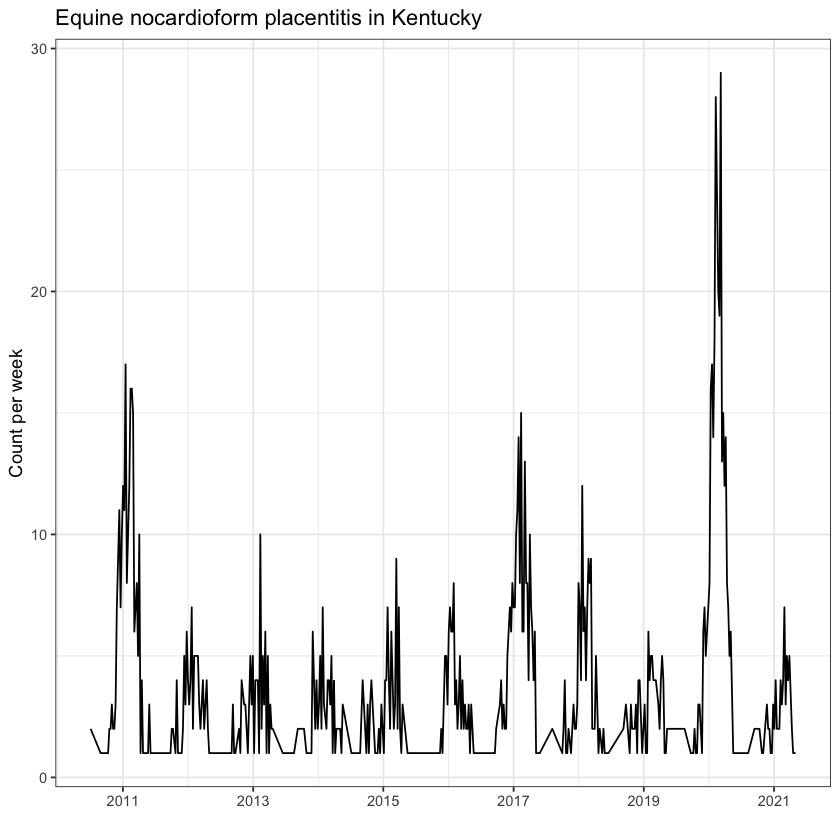

In [1]:
library(MMWRweek)
library(ggplot2)

# set path as needed

#setwd("~/RawData/OutFiles")

# Trends calculated in 2 ways:
# 1. Median quantiles
# 2. Quantile regression with week as predictor and splines as smoothers



################################################################
#### Load raw data 
################################################################

# the raw data can be downloaded from the University of Kentucky's Veterinary Diagnostic Laboratory (VDL) Dashboard: Historical
# picture of nocardioform placentitis in Kentucky 

# https://nam04.safelinks.protection.outlook.com/?url=http%3A%2F%2Fvdl.uky.edu%3A8080%2Finformer%2FDashboardViewer.html%3Flocale%3Den_US%26embedToken%3Dd58d8dbf-bef0-4619-b57c-9d4343260338&data=02%7C01%7Chfwiem2%40uky.edu%7Cfa8358fd86d54918098808d7a8e987b4%7C2b30530b69b64457b818481cb53d42ae%7C0%7C0%7C637163593278757986&sdata=xctfebsHFsOyY%2BttUSbOzFvXJHJUAfO9bgrfQv17oL4%3D&reserved=0


# Using read.csv() to read all downloaded csv-files, put in list
# bind with rbind

list_csv_files <- list.files(path = "~/animal_mortality/RawData/NCP",
                             pattern="*.csv", full.names = TRUE)
NCP = do.call(rbind, lapply(list_csv_files, function(x) read.csv(x, stringsAsFactors = FALSE)))

################################################################

# check formatting with str()


### format date

NCP$SubmittedDate <- as.Date(NCP$SubmittedDate,"%Y-%m-%d %H:%M:%S")

### write MMWR week into new column

NCP$Week <- MMWRweek(NCP$SubmittedDate)[,2]
NCP$Week <- sprintf("%02d", NCP$Week)

NCP$Year <- as.integer(c(strftime(NCP$SubmittedDate, format = "%Y")))
NCP$WeekYr <- c(paste(NCP$Year,NCP$Week,sep="-"))
NCP$WeekYear <- as.character(strftime((NCP$SubmittedDate), "%Y-%U",tz="CET"))

NCP$WeekDate <- cut(as.Date(NCP$SubmittedDate), "week",start.on.monday = FALSE)

################################################################

### aggregate by week

NCP_week <- aggregate(NCP, by=list(NCP$WeekDate), FUN=length)[,1:2]
colnames(NCP_week) <- c("WeekDate","Count")
NCP_week$WeekDate <- as.Date(NCP_week$WeekDate, "%Y-%m-%d")


################################################################
#### Graphics 
################################################################
### NCP cases per week since 2010

theme_set(theme_bw())
ggplot(NCP_week)+
  geom_line(aes(x=WeekDate,y=Count))+
  scale_x_date(#limits = c(as.Date("2019-01-01"), NA),
    date_breaks = '2 year', date_labels = '%Y')+
  labs(title = 'Equine nocardioform placentitis in Kentucky',
       #subtitle ='',
       #caption = '',
       x = '', y="Count per week")

In [ ]:
head(NCP_week)
library(zoo)
NCP_week = NCP_week %>% mutate(ma=rollapply(log(Count, base = exp(1)),6,mean,align='center',fill=NA))

library("dplyr")
library("tidyr")
library("lubridate")
state_centered = NCP_week %>% reframe(
    ma = ma,
    Count=Count,
    logcount = log(Count),
    median = find_median(ma, WeekDate),
    std = find_sd(ma, WeekDate),
    upper = find_quantile(ma, WeekDate, q=0.975),
    lower = find_quantile(ma, WeekDate, q=0.025),
    WeekDate = WeekDate)
state_centered$centered = exp(state_centered$ma - state_centered$median) - 1
state_centered$centered_high = exp(state_centered$ma - (state_centered$lower)) - 1
state_centered$centered_low = exp(state_centered$ma - (state_centered$upper)) - 1
head(state_centered)


Warning message:
“Removed 5 rows containing missing values (`geom_line()`).”


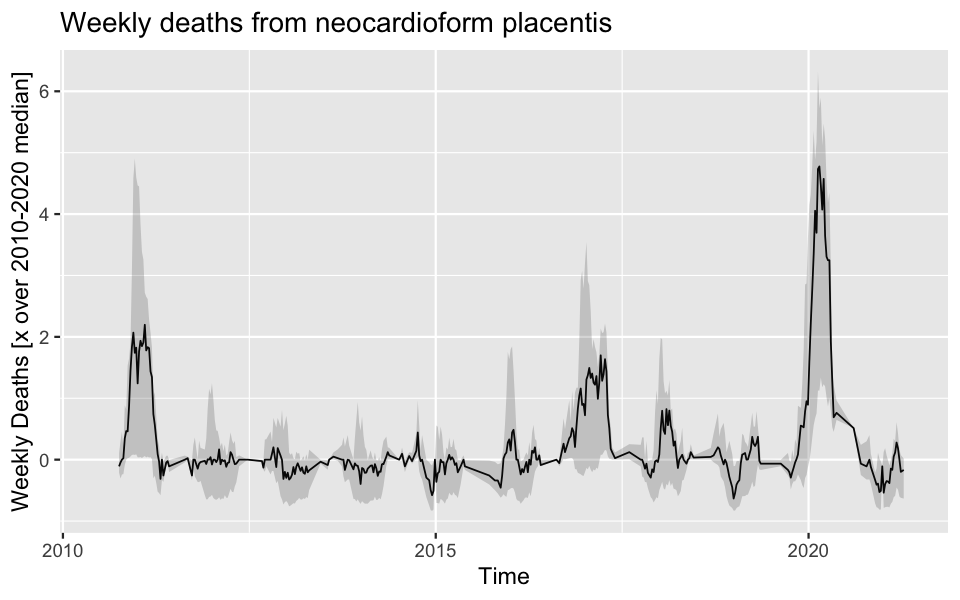

In [237]:
options(repr.plot.width=8, repr.plot.height=5)
b = ggplot(state_centered, aes(x=WeekDate, y=centered)) + geom_line() +
 geom_ribbon(aes(ymin=centered_low, ymax=centered_high), alpha = 0.2) +
 labs(x = "Time", y = "Weekly Deaths [x over 2010-2020 median]", title="Weekly deaths from neocardioform placentis") + 
theme_gray(base_size = 14) 
b

In [235]:
?legend

legend {graphics},R Documentation
"x, y",the x and y co-ordinates to be used to position the legend. They can be specified by keyword or in any way which is accepted by xy.coords: See ‘Details’.
legend,a character or expression vector of length \ge 1 to appear in the legend. Other objects will be coerced by as.graphicsAnnot.
fill,"if specified, this argument will cause boxes filled with the specified colors (or shaded in the specified colors) to appear beside the legend text."
col,the color of points or lines appearing in the legend.
border,the border color for the boxes (used only if fill is specified).
"lty, lwd",the line types and widths for lines appearing in the legend. One of these two must be specified for line drawing.
pch,"the plotting symbols appearing in the legend, as numeric vector or a vector of 1-character strings (see points). Unlike points, this can all be specified as a single multi-character string. Must be specified for symbol drawing."
angle,angle of shading lines.
density,"the density of shading lines, if numeric and positive. If NULL or negative or NA color filling is assumed."
bty,"the type of box to be drawn around the legend. The allowed values are ""o"" (the default) and ""n""."


In [233]:
ggsave("excessNCP.png", width=8, height=5)

Warning message:
“Removed 5 rows containing missing values (`geom_line()`).”
